# Class Project, CS 235, Fall 2021, Dr. Papalexakis
## 
## Gaussian Process Regression on California Housing Data
## by Mark Ma, 11/6/2021
###
### Dataset URL: https://www.kaggle.com/fedesoriano/california-housing-prices-data-extra-features?select=California_Houses.csv
###

    The dataset consists of 14 columns, or features, and 20,640 rows. Per the original provider, the dataset is fairly clean to begin with. We intend to verify that there is no missing data, then divide the data into 3 sets as follows -- 81% training, 9% validation, and 10% test.

    The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. The columns are as follows, their names are pretty self-explanatory:
    
    1) Median House Value: Median house value for households within a block (measured in US Dollars)
    2) Median Income: Median income for households within a block of houses (measured in tens of thousands of US Dollars) 
    3) Median Age: Median age of a house within a block; a lower number is a newer building (years)
    4) Total Rooms: Total number of rooms within a block
    5) Total Bedrooms: Total number of bedrooms within a block
    6) Population: Total number of people residing within a block
    7) Households: Total number of households, a group of people residing within a home unit, for a block
    8) Latitude: A measure of how far north a house is; a higher value is farther north (°)
    9) Longitude: A measure of how far west a house is; a higher value is farther west (°)
    10) Distance to coast: Distance to the nearest coast point (m)
    11) Distance to Los Angeles: Distance to the centre of Los Angeles (m)
    12) Distance to San Diego: Distance to the centre of San Diego (m)
    13) Distance to San Jose: Distance to the centre of San Jose (m)
    14) Distance to San Francisco: Distance to the centre of San Francisco (m)

    3 Engineered features are added: 
    15) Bedroom Density: Population (6) / Total Bedrooms (5)
    16) Avg Rooms per Household: Total Rooms (4) / Households (7)
    17) Distance to nearest majot city: minimum of columns (11), (12), (13) and (14)
    
    RecordID (18) and SetID (19) are added for ease of dividing the original dataset into Training (Observation), Validation and Test. 
    
    Features 8 and 9, latitude and longitude, should really be treated together as one feature -- coordinate. But unfortunately, the SciKit-Learn implementation of GPR does not provide a way to handle both 2-D vector and scalar features. 
    
    The first part of the code is based on SciKit-Learn. With the first plot and code block examining house price as a function of latitude and longitude. The second examining house price as a function of income and the third code block comparing the mean squared error of the first two approach versus using all features.  

Time for fitting - latitude and longitude: 37.104
GPML kernel: 1**2 * RBF(length_scale=1)
Log-marginal-likelihood: -45012717.325
MSE - Latitude and Longitude: 8312.914


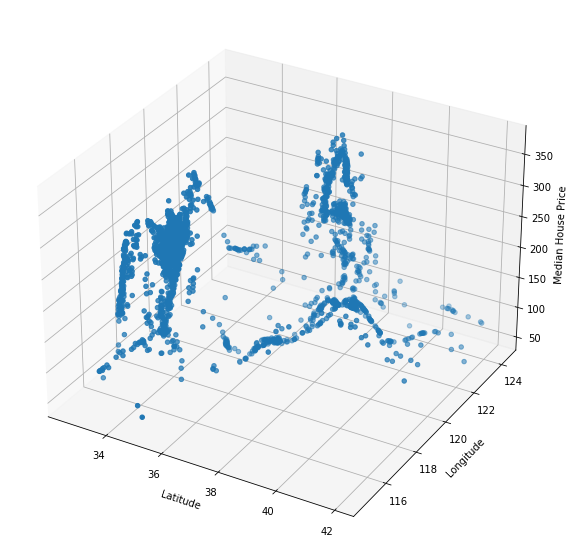

In [6]:
import numpy as np
import time

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    RationalQuadratic,
    ExpSineSquared,
    ConstantKernel
)

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import pandas as pd

obs_df = pd.read_csv('CA_HomePrice_Obs.csv')
val_df = pd.read_csv('CA_HomePrice_Val.csv')
test_df = pd.read_csv('CA_HomePrice_Test.csv')

# display(df)
# b = df.iloc[:,0:1].values
# print(b)

# Specify a GP prior
# kernel = 1 * RBF(length_scale = 1)
# gp = GaussianProcessRegressor(kernel = kernel, optimizer = None)
# print("Initial Kernel\n%s" % kernel)

obs_df_array = np.asarray(obs_df)
obs_price = obs_df_array[:, 0] / 1000
obs_income = obs_df_array[:, 1]
obs_lat = obs_df_array[:, 7]
obs_long = np.absolute(obs_df_array[:, 8])
obs_dist_coast = np.absolute(obs_df_array[:, 9])
obs_br_density = np.absolute(obs_df_array[:, 14])
obs_avg_rms = np.absolute(obs_df_array[:, 15])
obs_dist_city = np.absolute(obs_df_array[:, 16])

val_df_array = np.asarray(val_df)
val_price = val_df_array[:, 0] / 1000  
val_income = val_df_array[:, 1]
val_lat = val_df_array[:, 7]
val_long = np.absolute(val_df_array[:, 8])
val_dist_coast = np.absolute(val_df_array[:, 9])
val_br_density = np.absolute(val_df_array[:, 14])
val_avg_rms = np.absolute(val_df_array[:, 15])
val_dist_city = np.absolute(val_df_array[:, 16])

test_df_array = np.asarray(test_df)
test_price = test_df_array[:, 0] / 1000 
test_income = test_df_array[:, 1]
test_lat = test_df_array[:, 7]
test_long = np.absolute(test_df_array[:, 8])
test_dist_coast = np.absolute(test_df_array[:, 9])
test_br_density = np.absolute(test_df_array[:, 14])
test_avg_rms = np.absolute(test_df_array[:, 15])
test_dist_city = np.absolute(test_df_array[:, 16])


X_train = np.asarray([obs_lat, obs_long]).T
Y_train = obs_price.T
x_test = np.asarray([test_lat, test_long]).T

y_actual = test_price.T

# X is an array of arrays
# y is a vector

# Kernel with parameters given in GPML book
k0 = 1 * RBF(length_scale = 1)
k1 = 66.0 ** 2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = (
    2.4 ** 2
    * RBF(length_scale=90.0)
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)
)  # seasonal component
# medium term irregularity
k3 = 0.66 ** 2 * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18 ** 2 * RBF(length_scale=0.134) + WhiteKernel(
    noise_level=0.19 ** 2
)  # noise terms

k5 = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0)

# kernel_gpml = k1 + k2 + k3 + k4
kernel_gpml = k4

# gp = GaussianProcessRegressor(kernel=kernel_gpml, optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

gp = GaussianProcessRegressor(optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

stime = time.time()
gp.fit(X_train, Y_train)
print("Time for fitting - latitude and longitude: %.3f" % (time.time() - stime))

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

y_pred, y_std = gp.predict(x_test, return_std=True)

# display(y_pred)
# display(y_std)
# display(x_test)

# calculate MSE for lat + long  
mse_latlong = mean_squared_error(y_actual, y_pred)
print("MSE - Latitude and Longitude: %.3f" % mse_latlong)

# Create a 3D plot of price v lat+long
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(x_test[:,0], x_test[:,1], y_pred, marker='o')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Median House Price')

plt.show()


Time for fitting - income only: 25.959
GPML kernel: 1**2 * RBF(length_scale=1)
Log-marginal-likelihood: -37948518.220


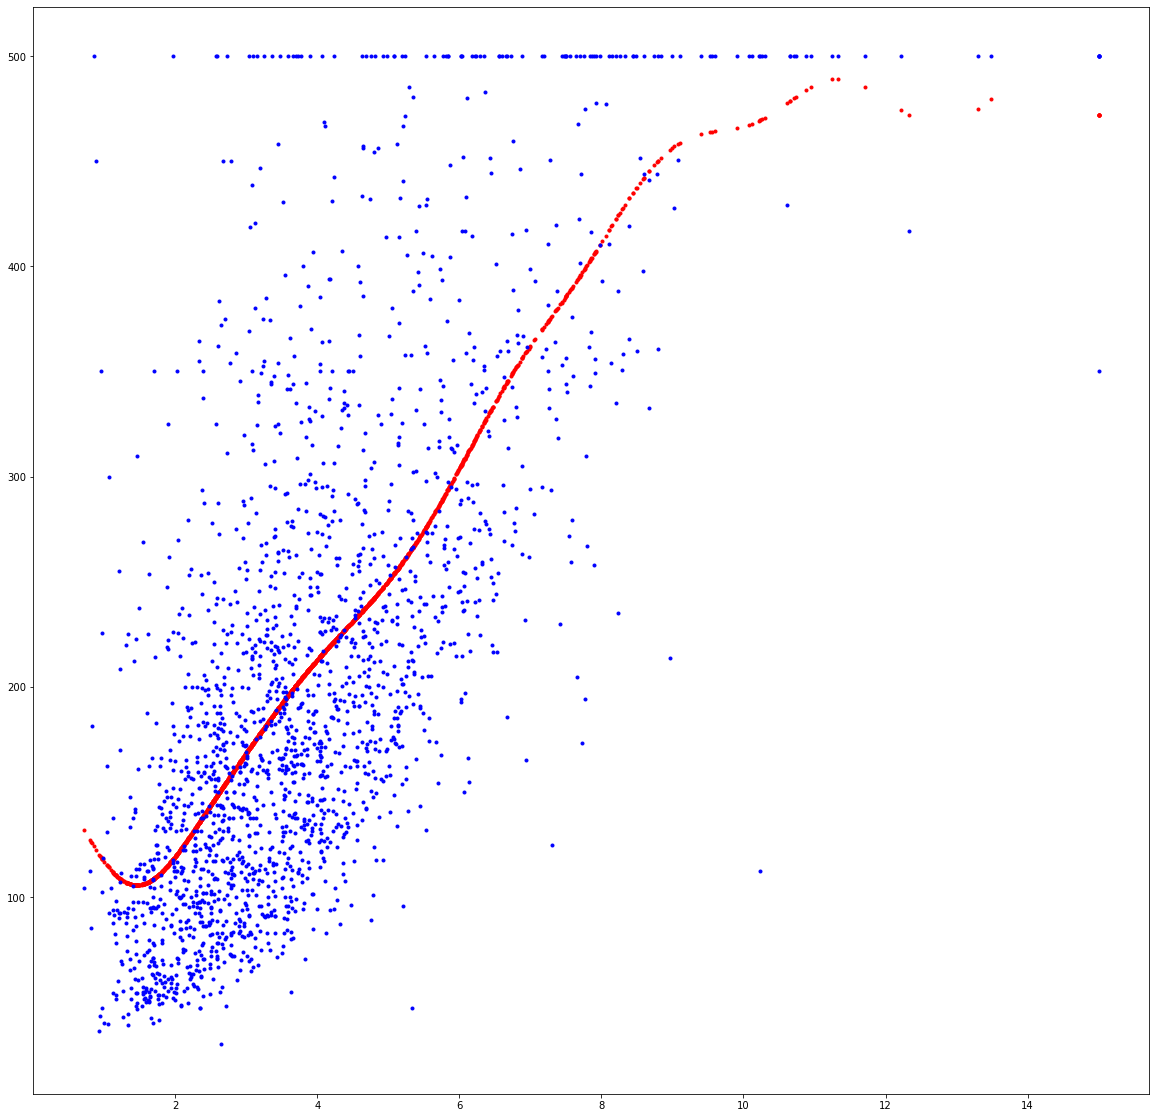

In [7]:
X_train = obs_income.reshape(-1, 1)
Y_train = obs_price
x_test = test_income.reshape(-1, 1)
y_actual = test_price

# Kernel with parameters given in GPML book
k0 = 1 * RBF(length_scale = 1)
k1 = 66.0 ** 2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = (
    2.4 ** 2
    * RBF(length_scale=90.0)
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)
)  # seasonal component
# medium term irregularity
k3 = 0.66 ** 2 * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18 ** 2 * RBF(length_scale=0.134) + WhiteKernel(
    noise_level=0.19 ** 2
)  # noise terms

k5 = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0)

# kernel_gpml = k1 + k2 + k3 + k4
kernel_gpml = k4

# gp = GaussianProcessRegressor(kernel=kernel_gpml, optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

gp = GaussianProcessRegressor(optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

stime = time.time()
gp.fit(X_train, Y_train)
print("Time for fitting - income only: %.3f" % (time.time() - stime))

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

y_pred, y_std = gp.predict(x_test, return_std=True)

# mse_income = (np.square(y_actual - y_pred)).mean(axis = 0)
mse_income = np.mean((y_actual - y_pred)**2)

# Create a 2D plot of price v income
fig_2D = plt.figure(figsize=(20,20))
plt.plot(x_test, y_pred, 'r.', label='Predictions')
plt.plot(x_test, y_actual, 'b.', label='Actual')
plt.show()



In [8]:
X_train = np.asarray([obs_income, obs_lat, obs_long, obs_dist_coast, obs_br_density, obs_avg_rms, obs_dist_city]).T
Y_train = obs_price.T
x_test = np.asarray([test_income, test_lat, test_long, test_dist_coast, test_br_density, test_avg_rms, test_dist_city]).T

y_actual = test_price.T

# Kernel with parameters given in GPML book
k0 = 1 * RBF(length_scale = 1)
k1 = 66.0 ** 2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = (
    2.4 ** 2
    * RBF(length_scale=90.0)
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)
)  # seasonal component
# medium term irregularity
k3 = 0.66 ** 2 * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18 ** 2 * RBF(length_scale=0.134) + WhiteKernel(
    noise_level=0.19 ** 2
)  # noise terms

k5 = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0)

# kernel_gpml = k1 + k2 + k3 + k4
kernel_gpml = k4

# gp = GaussianProcessRegressor(kernel=kernel_gpml, optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

gp = GaussianProcessRegressor(optimizer = 'fmin_l_bfgs_b',alpha = 1.5, n_restarts_optimizer=1)

stime = time.time()
gp.fit(X_train, Y_train)
print("Time for fitting - latitude + longitude: %.3f" % (time.time() - stime))

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))

y_pred, y_std = gp.predict(x_test, return_std=True)

mse_all = np.mean((y_actual - y_pred)**2)

# display(y_actual)
# display(y_pred)

print("MSE, Latitude + Longitude: ")
display(mse_latlong)

print("MSE, income only: ")
display(mse_income)

print("MSE, all features: ")
display(mse_all)


Time for fitting - latitude + longitude: 33.210
GPML kernel: 1**2 * RBF(length_scale=1)
Log-marginal-likelihood: -162752629.986
MSE, Latitude + Longitude: 


8312.914197559638

MSE, income only: 


7172.71084505753

MSE, all features: 


42238.997994968704